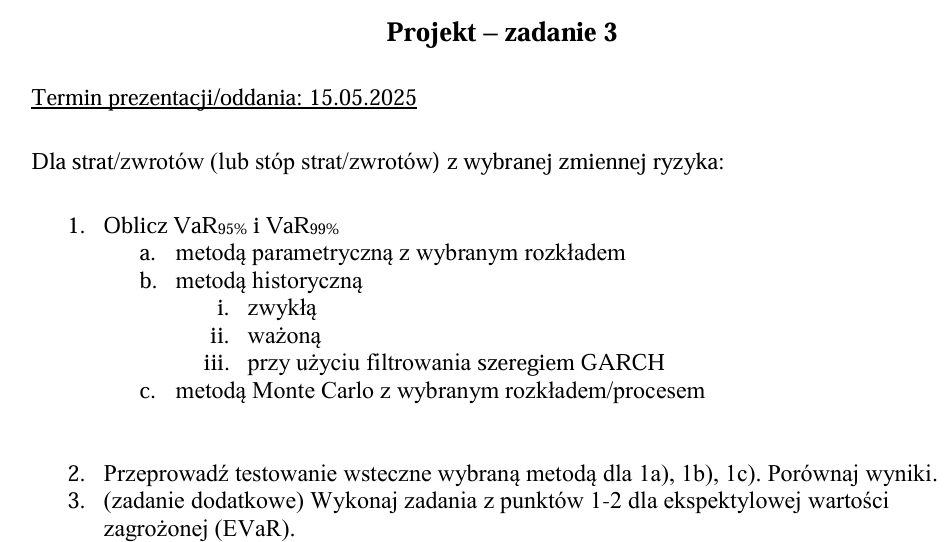

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import norm
import numpy as np
from scipy.optimize import minimize_scalar

In [3]:
# Wczytaj plik
df = pd.read_csv('fuel_output.csv', sep=';')

# Wyodrębnij kolumny do zmiennych
dates = pd.to_datetime(df['Date'])

fuel_data = df['fuel_data']
logret_fuel_data = df['logret_fuel_data'][1:]
logret_fuel_data=logret_fuel_data.values

A) metoda parametryczna - paliwo t-student

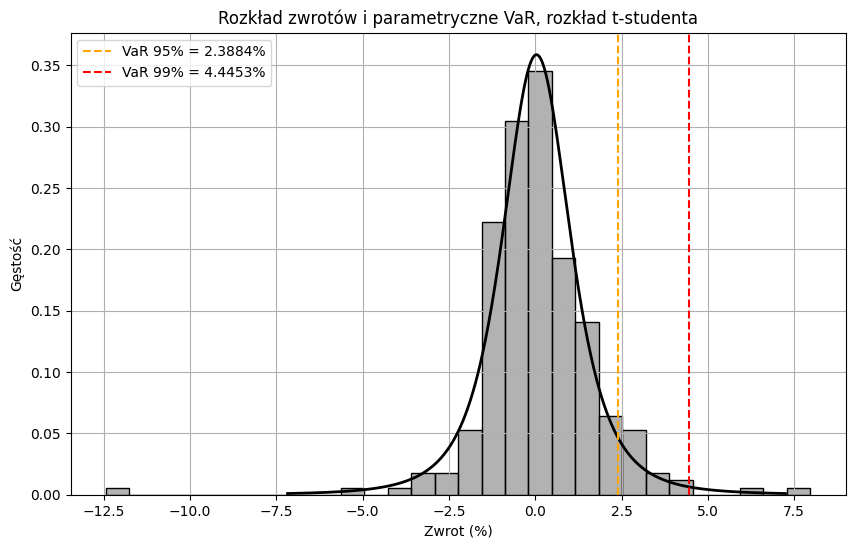

3.243723713943763 0.000355716098170116 0.010305755405206837


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns


# Dopasowanie rozkładu studenta-t
df, loc, scale = stats.t.fit(logret_fuel_data)

# Wyznaczenie VaR na prawej stronie (duże zyski = prawe ogony)
alpha_95 = 0.95
alpha_99 = 0.99

z_95 = stats.t.ppf(alpha_95, df)
z_99 = stats.t.ppf(alpha_99, df)

VaR_95 = loc + z_95 * scale
VaR_99 = loc + z_99 * scale

x = np.linspace(loc - 7*scale, loc + 7*scale, 1000)
pdf = stats.t.pdf(x, df, loc, scale) / 100


x = x * 100

# Rysowanie
plt.figure(figsize=(10, 6))
sns.histplot(logret_fuel_data * 100, stat='density', bins=30, color='gray', alpha=0.6)
plt.plot(x, pdf, linewidth=2, color='black')

# Linie VaR (po prawej stronie)
plt.axvline(VaR_95 * 100, color='orange', linestyle='--', label=f"VaR 95% = {VaR_95*100:.4f}%")
plt.axvline(VaR_99 * 100, color='red', linestyle='--', label=f"VaR 99% = {VaR_99*100:.4f}%")

# Oznaczenia
plt.title('Rozkład zwrotów i parametryczne VaR, rozkład t-studenta')
plt.xlabel('Zwrot (%)')
plt.ylabel('Gęstość')
plt.legend()
plt.grid(True)
plt.show()
print(df, loc, scale)


test Kolmogorova-Smirnova

KS test D-statistic: 0.0442
KS test p-value: 0.6949


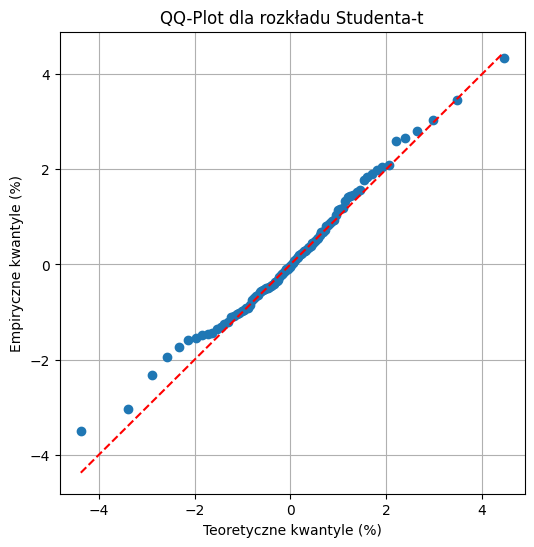

In [4]:

# Test dopasowania: Kolmogorov-Smirnov
D_statistic, p_value = stats.kstest(logret_fuel_data, 't', args=(df, loc, scale))

print(f"KS test D-statistic: {D_statistic:.4f}")
print(f"KS test p-value: {p_value:.4f}")

# QQ-plot (kwantyl-kwantyl)
theoretical_quantiles = stats.t.ppf(np.linspace(0.01, 0.99, 100), df, loc, scale)
sample_quantiles = np.quantile(logret_fuel_data, np.linspace(0.01, 0.99, 100))

plt.figure(figsize=(6, 6))
plt.plot(theoretical_quantiles * 100, sample_quantiles * 100, 'o')
plt.plot(theoretical_quantiles * 100, theoretical_quantiles * 100, 'r--')
plt.title('QQ-Plot dla rozkładu Studenta-t')
plt.xlabel('Teoretyczne kwantyle (%)')
plt.ylabel('Empiryczne kwantyle (%)')
plt.grid(True)
plt.show()


b) metoda historyczna

i) zwykla

Historyczny VaR 95% (zwykły): 2.6462%
Historyczny VaR 99% (zwykły): 4.3359%


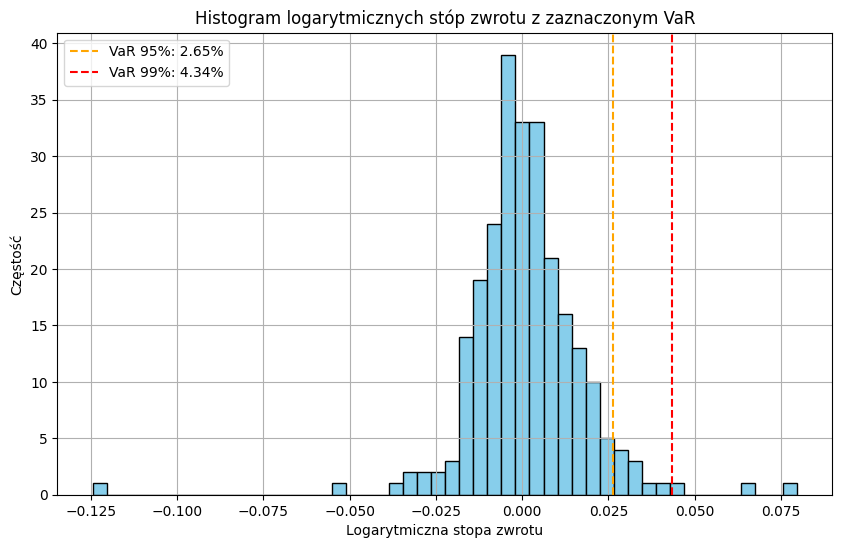

In [41]:
import numpy as np
import matplotlib.pyplot as plt

alpha_95 = 0.95
alpha_99 = 0.99

# Historyczny VaR (zwykły)
VaR_hist_95 = np.percentile(logret_fuel_data, 100 * ( alpha_95))
VaR_hist_99 = np.percentile(logret_fuel_data, 100 * (alpha_99))

print(f"Historyczny VaR 95% (zwykły): {VaR_hist_95*100:.4f}%")
print(f"Historyczny VaR 99% (zwykły): {VaR_hist_99*100:.4f}%")

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(logret_fuel_data, bins=50, color='skyblue', edgecolor='black')
plt.axvline(VaR_hist_95, color='orange', linestyle='--', label=f'VaR 95%: {VaR_hist_95*100:.2f}%')
plt.axvline(VaR_hist_99, color='red', linestyle='--', label=f'VaR 99%: {VaR_hist_99*100:.2f}%')
plt.title('Histogram logarytmicznych stóp zwrotu z zaznaczonym VaR')
plt.xlabel('Logarytmiczna stopa zwrotu')
plt.ylabel('Częstość')
plt.legend()
plt.grid(True)
plt.show()


Historyczny VaR 95% (zwykły): 2.6462%
Historyczny VaR 99% (zwykły): 4.3359%


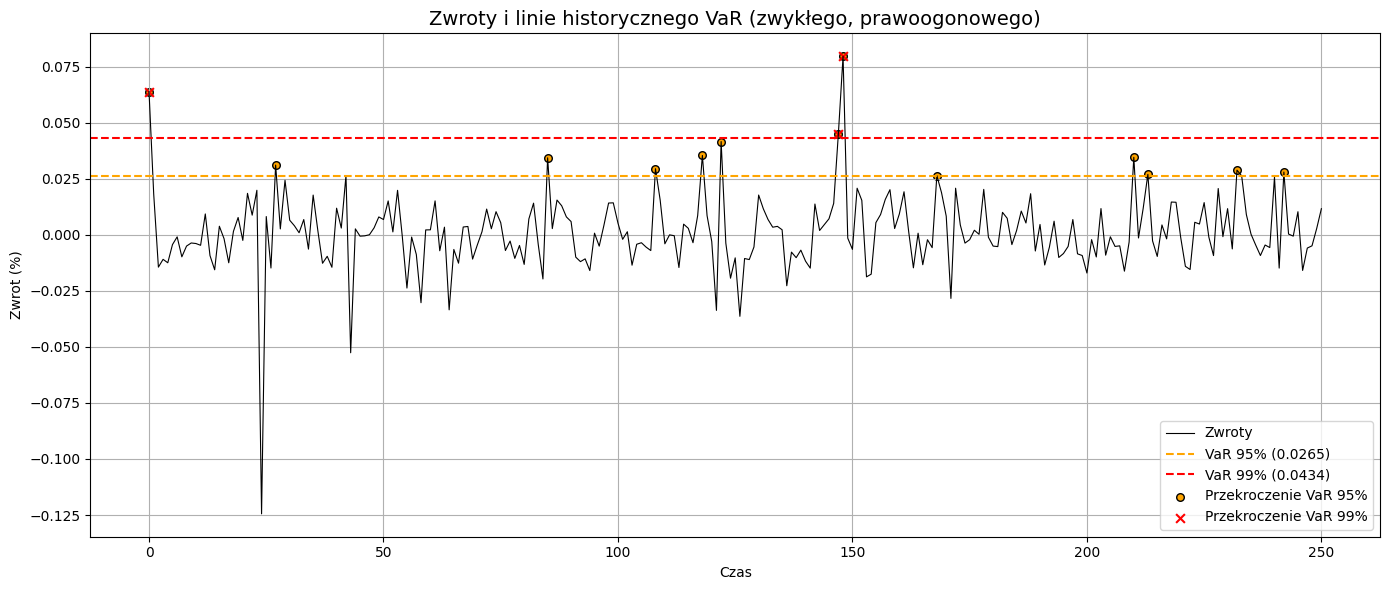

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Poziomy istotności
alpha_95 = 0.95
alpha_99 = 0.99

# Historyczny VaR (dla ryzyka wzrostu)
VaR_hist_95 = np.percentile(logret_fuel_data, 100 * alpha_95)
VaR_hist_99 = np.percentile(logret_fuel_data, 100 * alpha_99)

print(f"Historyczny VaR 95% (zwykły): {VaR_hist_95*100:.4f}%")
print(f"Historyczny VaR 99% (zwykły): {VaR_hist_99*100:.4f}%")

# Wykres jak w GARCH / MC
plt.figure(figsize=(14, 6))
plt.plot(logret_fuel_data, label='Zwroty', color='black', linewidth=0.8)
plt.axhline(VaR_hist_95, color='orange', linestyle='--', label=f'VaR 95% ({VaR_hist_95:.4f})')
plt.axhline(VaR_hist_99, color='red', linestyle='--', label=f'VaR 99% ({VaR_hist_99:.4f})')

# Przekroczenia
exceed_95 = logret_fuel_data > VaR_hist_95
exceed_99 = logret_fuel_data > VaR_hist_99

plt.scatter(np.where(exceed_95)[0], logret_fuel_data[exceed_95],
            color='orange', label='Przekroczenie VaR 95%', marker='o', s=30, edgecolors='k')
plt.scatter(np.where(exceed_99)[0], logret_fuel_data[exceed_99],
            color='red', label='Przekroczenie VaR 99%', marker='x', s=40)

# Formatowanie
plt.title('Zwroty i linie historycznego VaR (zwykłego, prawoogonowego)', fontsize=14)
plt.xlabel('Czas')
plt.ylabel('Zwrot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ii) ważony -  wagi wykładnicze, czyli najnowsze dane mają większe znaczenie.

In [43]:


# Parametry
lambda_ = 0.96
alpha_95 = 0.95
alpha_99 = 0.99

# Dane: załóżmy, że masz już wczytane logret_fuel_data jako np.array
n = len(logret_fuel_data)

# 1. Wyznaczanie wag wykładniczych zgodnie z metodą
raw_weights = lambda_ ** np.arange(n-1, -1, -1)  # lambda^0 dla najnowszej obserwacji
w1 = (1 - lambda_) / (1 - lambda_ ** n)           # Wyznaczenie w(1) z warunku normalizacji
weights = w1 * raw_weights                       # Ostateczne wagi
weights /= weights.sum()                         # (opcjonalna dodatkowa normalizacja dla bezpieczeństwa)

# 2. Sortowanie danych wg wartości zwrotów
sorted_indices = np.argsort(logret_fuel_data)
sorted_returns = logret_fuel_data[sorted_indices]
sorted_weights = weights[sorted_indices]

# 3. Skumulowane prawdopodobieństwa
cum_weights = np.cumsum(sorted_weights)

# 4. Funkcja do wyszukiwania VaR
def weighted_var(cum_weights, sorted_returns, alpha):
    target = alpha  # szukamy kwantyla na poziomie 1 - alpha
    idx = np.searchsorted(cum_weights, target, side="left")
    idx = min(idx, len(sorted_returns) - 1)  # zabezpieczenie
    return sorted_returns[idx]

# 5. Obliczenie VaR
VaR_weighted_95 = weighted_var(cum_weights, sorted_returns, alpha_95)
VaR_weighted_99 = weighted_var(cum_weights, sorted_returns, alpha_99)

print(f"Historyczny VaR 95% (ważony): {VaR_weighted_95*100:.4f}%")
print(f"Historyczny VaR 99% (ważony): {VaR_weighted_99*100:.4f}%")


Historyczny VaR 95% (ważony): 2.8020%
Historyczny VaR 99% (ważony): 2.8884%


iii) GARCH

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                680.538
Distribution:                  Normal   AIC:                          -1353.08
Method:            Maximum Likelihood   BIC:                          -1338.97
                                        No. Observations:                  251
Date:                Sun, May 11 2025   Df Residuals:                      250
Time:                        11:36:00   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.8238e-04  1.777e-03     -0.159      0.

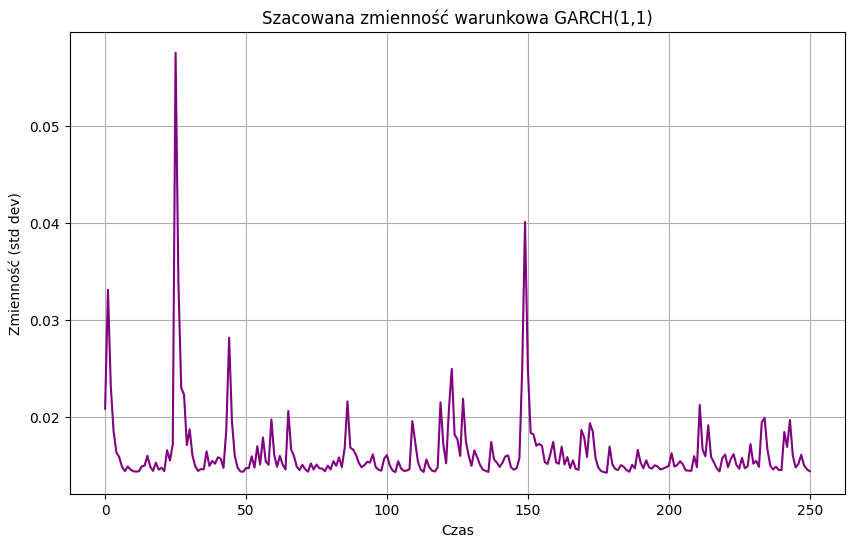

In [44]:
from arch import arch_model

# Przygotowanie danych
returns = logret_fuel_data  # Twoje logarytmiczne stopy zwrotu

# Dopasowanie modelu GARCH(1,1)
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp="off")

# Wyświetlenie pełnego podsumowania modelu
print(garch_fit.summary())

# Wykres zmienności (warunkowej standard deviation)
plt.figure(figsize=(10,6))
plt.plot(garch_fit.conditional_volatility, color='purple')
plt.title('Szacowana zmienność warunkowa GARCH(1,1)')
plt.xlabel('Czas')
plt.ylabel('Zmienność (std dev)')
plt.grid(True)
plt.show()


In [45]:
# Dopasowanie modelu GARCH(1,1)
model = arch_model(logret_fuel_data, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp="off")

# Obliczenie zmienności warunkowej (standard deviation) z modelu GARCH
conditional_volatility = garch_fit.conditional_volatility

# Obliczanie VaR na poziomie 95% i 99% dla modelu GARCH
VaR_garch_95 = np.percentile(conditional_volatility, 95)  # 5% percentyl dla VaR 95%
VaR_garch_99 = np.percentile(conditional_volatility, 99)  # 1% percentyl dla VaR 99%

# Wyświetlanie wyników VaR w procentach
print(f"GARCH VaR 95%: {VaR_garch_95 * 100:.4f}%")
print(f"GARCH VaR 99%: {VaR_garch_99 * 100:.4f}%")

GARCH VaR 95%: 2.1555%
GARCH VaR 99%: 3.3518%


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


wersja wery j - notatki z wykladu

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


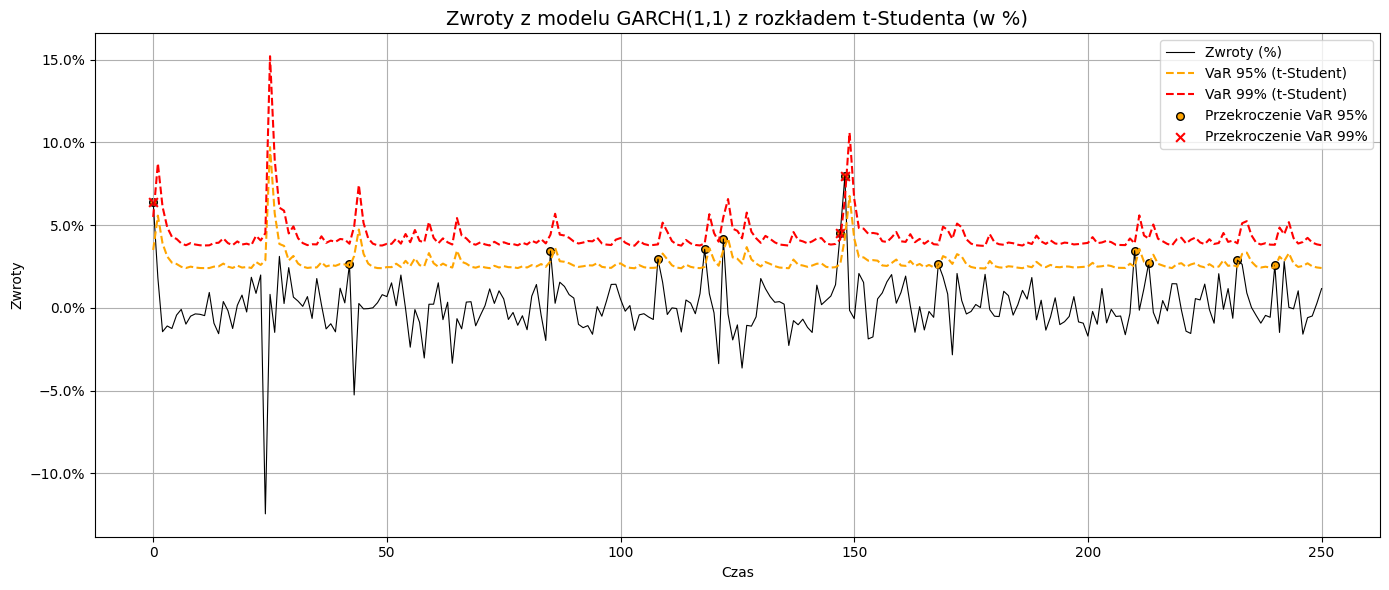

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

logret_fuel_data = pd.Series(logret_fuel_data, index=df.index)
# Dopasowanie modelu GARCH(1,1) z t-Studenta
model_t = arch_model(logret_fuel_data, vol='Garch', p=1, q=1)
garch_fit_t = model_t.fit(disp="off")

# Parametry
mu_t = garch_fit_t.params['mu']
cond_vol_t = garch_fit_t.conditional_volatility
standardized_residuals_t = garch_fit_t.resid / cond_vol_t

# Kwantyle (ryzyko wzrostu cen = prawy ogon)
VaR95_q_t = np.quantile(standardized_residuals_t, 0.95)
VaR99_q_t = np.quantile(standardized_residuals_t, 0.99)

# Obliczenie VaR (w procentach)
VaR_95_t = (cond_vol_t * VaR95_q_t + mu_t)
VaR_99_t = (cond_vol_t * VaR99_q_t + mu_t) 
returns_pct = logret_fuel_data 

VaR_95_t = pd.Series(VaR_95_t, index=logret_fuel_data.index)
VaR_99_t = pd.Series(VaR_99_t, index=logret_fuel_data.index)
# Przekroczenia
exceed_95_t = returns_pct > VaR_95_t
exceed_99_t = returns_pct > VaR_99_t

# Wykres
plt.figure(figsize=(14, 6))
plt.plot(returns_pct.index, returns_pct, label='Zwroty (%)', color='black', linewidth=0.8)
plt.plot(VaR_95_t.index, VaR_95_t, label='VaR 95% (t-Student)', color='orange', linestyle='--')
plt.plot(VaR_99_t.index, VaR_99_t, label='VaR 99% (t-Student)', color='red', linestyle='--')

plt.scatter(returns_pct.index[exceed_95_t], returns_pct[exceed_95_t],
            color='orange', label='Przekroczenie VaR 95%', marker='o', s=30, edgecolors='k')
plt.scatter(returns_pct.index[exceed_99_t], returns_pct[exceed_99_t],
            color='red', label='Przekroczenie VaR 99%', marker='x', s=40)

# Formatowanie
plt.title('Zwroty z modelu GARCH(1,1) z rozkładem t-Studenta (w %)', fontsize=14)
plt.xlabel('Czas')
plt.ylabel('Zwroty')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1)) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


VaR_garch_95=VaR_95
VaR_garch_99=VaR_99

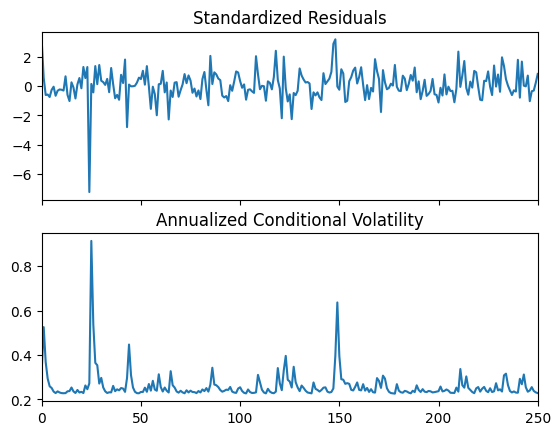

In [90]:
fig =garch_fit_t.plot(annualize='D')

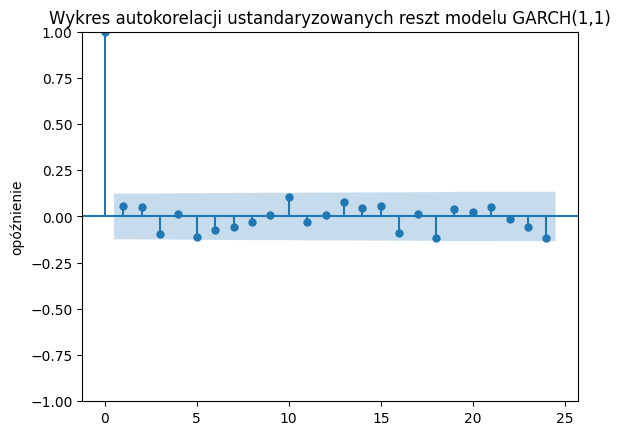

In [80]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(standardized_residuals_t)
plt.title("Wykres autokorelacji ustandaryzowanych reszt modelu GARCH(1,1)")
plt.ylabel("opóźnienie")
plt.show()

In [81]:
# Prognoza zmienności na kolejny dzień
forecast = garch_fit.forecast(horizon=1)
sigma_t1 = np.sqrt(forecast.variance.values[-1, 0])
mu=forecast.mean.values[-1, 0]

# Obliczenie wartości VaR na przyszlosc
VaR_garch_95 = sigma_t1 * VaR95_q_t+mu
VaR_garch_99 = sigma_t1 * VaR99_q_t + mu

print(f"VaR 95% (ryzyko wzrostu) na t+1: {VaR_garch_95*100:.4f}%")
print(f"VaR 99% (ryzyko wzrostu) na t+1: {VaR_garch_99*100:.4f}%")


VaR 95% (ryzyko wzrostu) na t+1: 2.5254%
VaR 99% (ryzyko wzrostu) na t+1: 4.1204%


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


c) Monte Carlo

t-student

In [48]:
# Liczba losowań (symulacje Monte Carlo)
N = 10000  # Duża liczba losowań (żeby kwantyle były dokładne)
n = len(logret_fuel_data)

VaR_mc_95_t_list = []
VaR_mc_99_t_list = []

for _ in range(N): 
    # Symulacja zwrotów
    simulated_returns = stats.t.rvs(df, loc, scale, size=n)

    # Liczenie VaR 95% i 99% z symulowanych danych
    VaR_mc_95_t_sample = np.percentile(simulated_returns, 100 * 0.95)
    VaR_mc_99_t_sample = np.percentile(simulated_returns, 100 * 0.99)

    VaR_mc_95_t_list.append(VaR_mc_95_t_sample)
    VaR_mc_99_t_list.append(VaR_mc_99_t_sample)

VaR_mc_95_t = np.mean(VaR_mc_95_t_list)
VaR_mc_99_t = np.mean(VaR_mc_99_t_list)

print(f"Monte Carlo VaR 95%: {VaR_mc_95_t*100:.4f}%")
print(f"Monte Carlo VaR 99%: {VaR_mc_99_t*100:.4f}%")

Monte Carlo VaR 95%: 2.3572%
Monte Carlo VaR 99%: 4.2604%


arma

In [ ]:
import statsmodels.api as sm

# Dopasowanie modelu ARMA(1,1)
arma_model = sm.tsa.ARIMA(logret_fuel_data, order=(1,0, 1)).fit()

# Wyciągnięcie parametrów
arparams = arma_model.arparams
maparams = arma_model.maparams
sigma = np.std(arma_model.resid, ddof=1)
# domyślnie 0, jeśli brak


# Parametry Monte Carlo
n_simulations = 500  # Ilość symulacji
n_steps = 1  # Jednokrokowe symulacje (jednodniowe VaR)

# Symulacja procesów ARMA(1,1)
VaR_mc_95_list=np.zeros(n_simulations)
VaR_mc_99_list=np.zeros(n_simulations)
for i in range(n_simulations):
    # Symulacja białego szumu
    eps = np.random.normal(0, sigma, n_steps + 1)
    
    # Symulacja procesu
    x = np.zeros(n_steps + 1)
    mu = arma_model.params[0] 
    for t in range(1, n_steps + 1):
        x[t] =mu+ arparams[0] * x[t-1] + eps[t] + maparams[0] * eps[t-1]
    
    simulated_returns.append(x[-1])  # interesuje nas ostatnia wartość (krok n_steps)

simulated_returns = np.array(simulated_returns)

# Liczenie VaR
VaR_mc_95 = np.percentile(simulated_returns, 100 * 0.95)
VaR_mc_99 = np.percentile(simulated_returns, 100 * 0.99)  # interesuje nas ostatnia wartość (krok n_steps)


print(f"Monte Carlo VaR 95% (ARMA(1,1)): {VaR_mc_95*100:.4f}%")
print(f"Monte Carlo VaR 99% (ARMA(1,1)): {VaR_mc_99*100:.4f}%")



Monte Carlo VaR 95% (ARMA(1,1)): 0.7782%
Monte Carlo VaR 99% (ARMA(1,1)): 0.8444%


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


podsumowanie: Czy tu zamiast Normlana nie powinno być t-Studenta? Czeemu nromlana?

hm, wydaje mi sie ze to ze dane sa z t-studenta nie ma znaczenia, bo jakbysmy wlozyli t-studenta zmiast normalnego to nie bylaby juz arma chyba

z GARCHem

In [51]:
VaR_95 = loc + z_95 * scale
VaR_99 = loc + z_99 * scale
var_results = pd.DataFrame({
    "VaR 95%": [
        VaR_95 * 100,  # Parametryczna (Normalna)
        VaR_hist_95 * 100,  # Historyczna (Zwykła)
        VaR_weighted_95 * 100,
        VaR_mc_95_t * 100,  # Historyczna (Ważona)
        VaR_mc_95 * 100,  # Monte Carlo (t-Student)
        VaR_garch_95 * 100  # GARCH
    ],
    "VaR 99%": [
        VaR_99 * 100,  # Parametryczna (Normalna)
        VaR_hist_99 * 100,  # Historyczna (Zwykła)
        VaR_weighted_99 * 100,
        VaR_mc_99_t * 100,  # Historyczna (Ważona)
        VaR_mc_99 * 100,  # Monte Carlo (t-Student)
        VaR_garch_99 * 100  # GARCH
    ]
}, index=[
    "Parametryczna (Normalna)",
    "Historyczna (Zwykła)",
    "Historyczna (Ważona)",
    "Monte Carlo (t-Student)",
    "Monte Carlo (ARMA(1,1))",
    "GARCH"
])

# Wyświetlenie tabeli
var_results.round(4)

VaR 95%  VaR 99%
Parametryczna (Normalna)   2.3884   4.4453
Historyczna (Zwykła)       2.6462   4.3359
Historyczna (Ważona)       2.8020   2.8884
Monte Carlo (t-Student)    2.3572   4.2604
Monte Carlo (ARMA(1,1))    2.3572   4.2604
GARCH                      2.5808   4.0362

proba z tymi wykresami, troche nie wiem o co w nich chodzi?
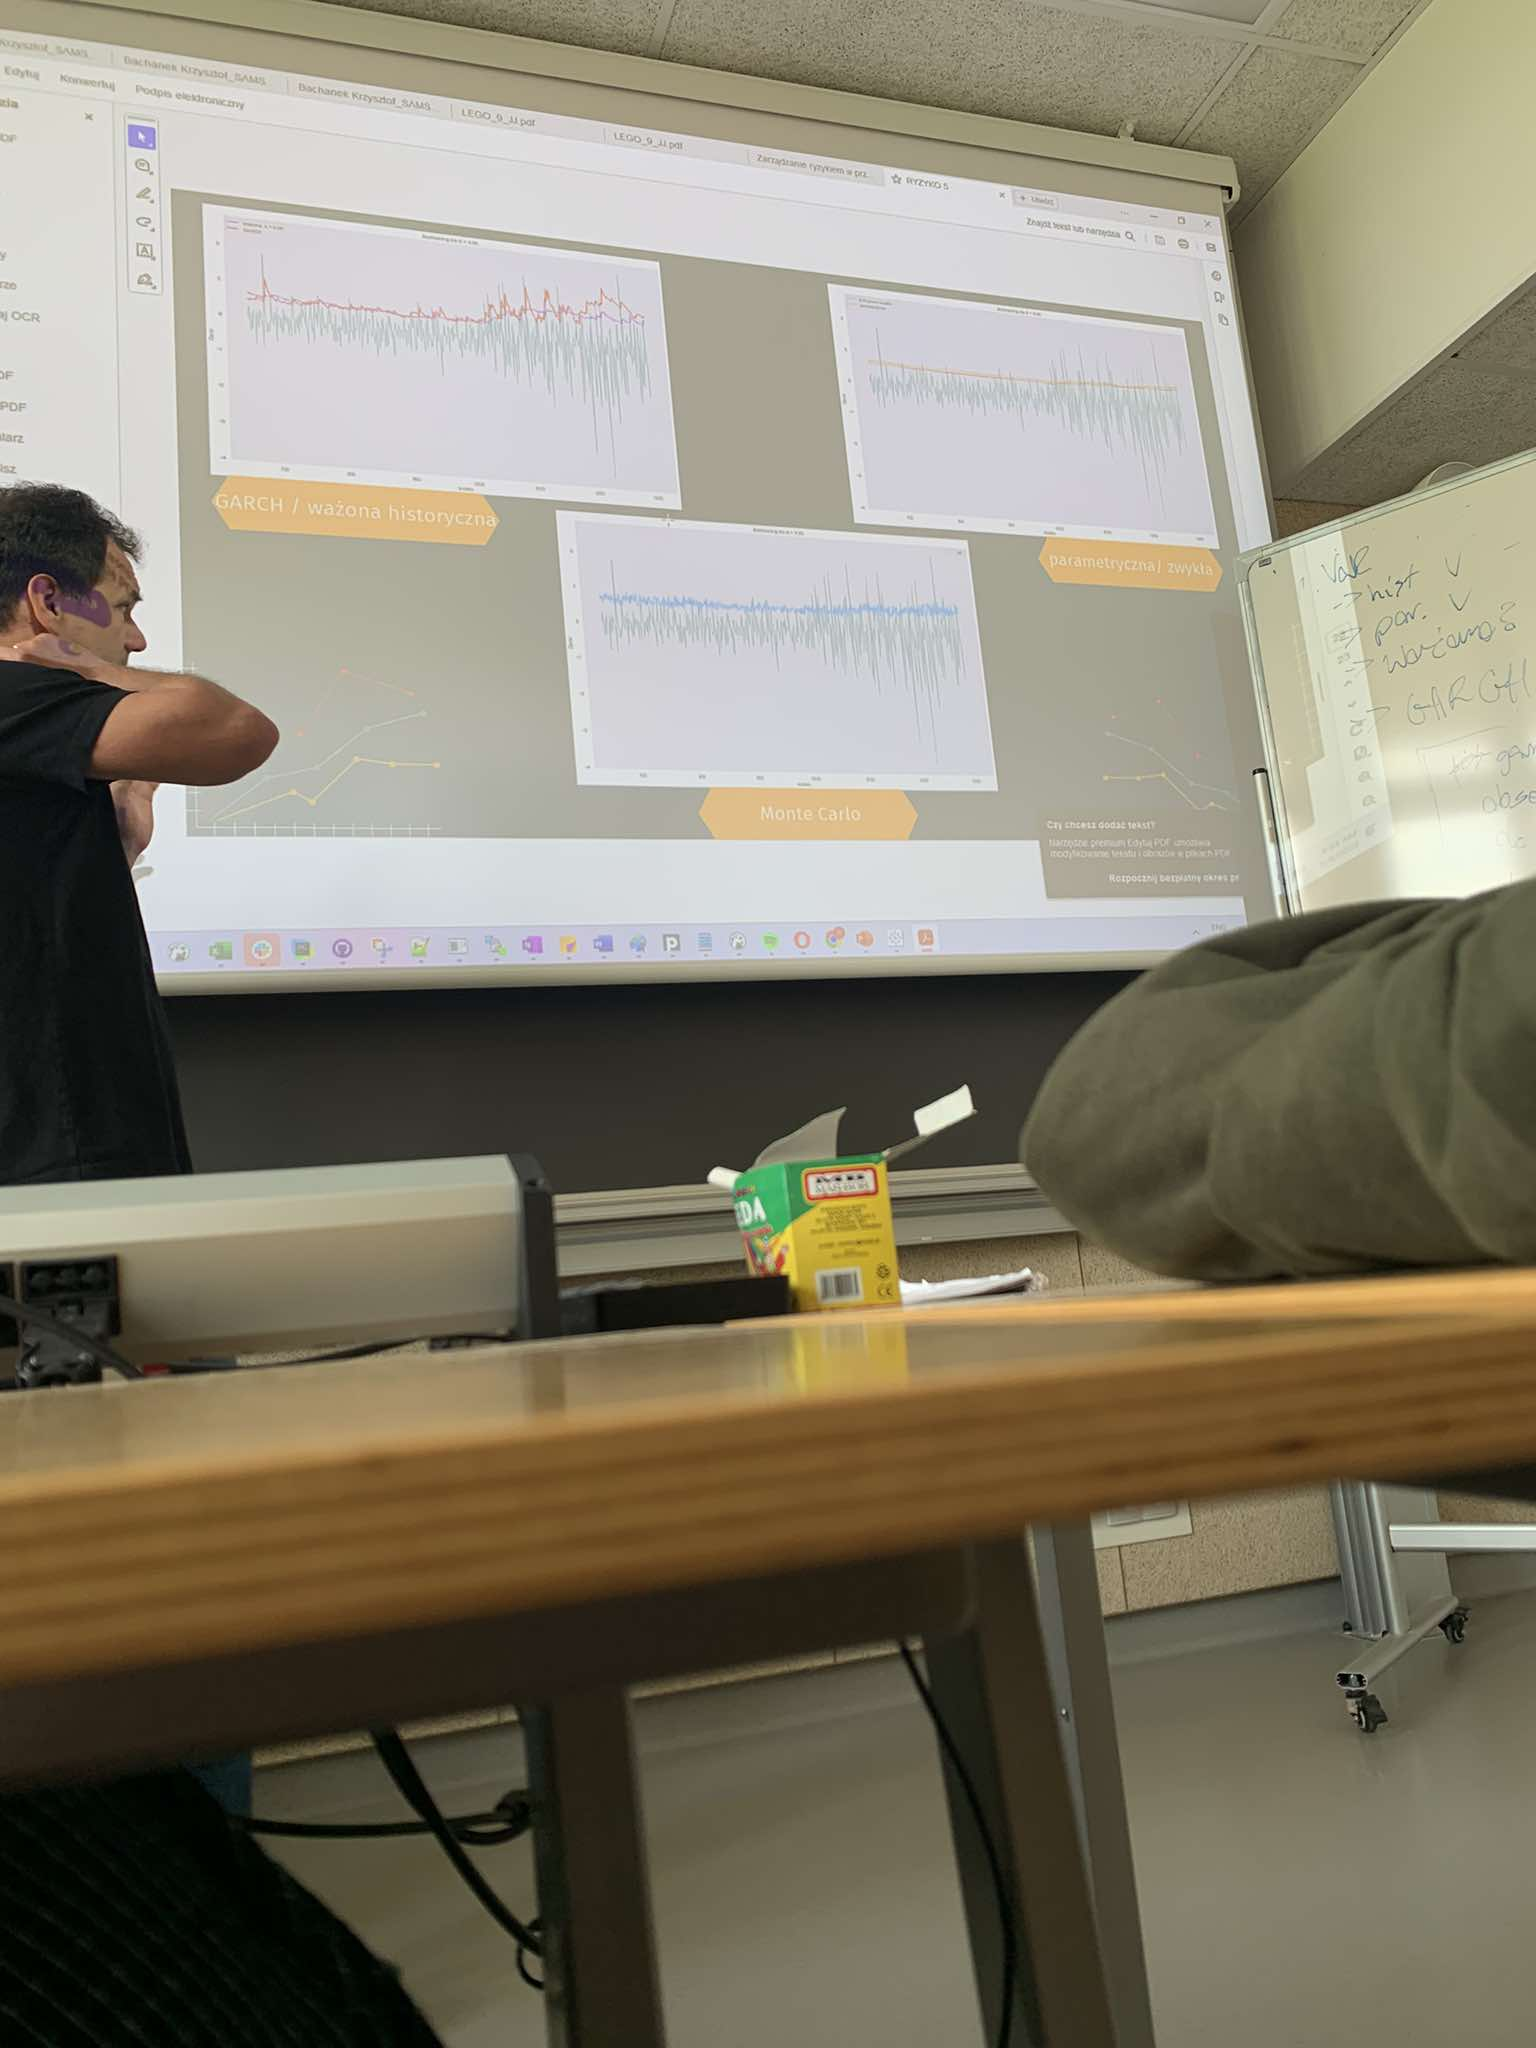

rolling historyczny/????

# Testowanie wsteczne

In [13]:
from scipy.stats import chi2, norm
from scipy.stats import chi2
import numpy as np

def kupiec_test(returns, var, alpha):
    """
    Test Kupca (Unconditional Coverage Test) – poprawiona wersja.

    Parameters:
    - returns: tablica zwrotów (np. logarytmiczne zwroty)
    - var: progowe wartości VaR (może być stałe lub seria)
    - alpha: poziom istotności (np. 0.95 dla VaR 95%)

    Returns:
    - statystyka LR_uc,
    - p-value,
    - liczba przekroczeń
    """

    T = len(returns)
    # Przekroczenia w PRAWO – ryzyko wzrostu
    breaches = returns > var
    n_breaches = breaches.sum()

    # Jeżeli brak przekroczeń lub wszystkie to przekroczenia – nie da się liczyć
    if n_breaches == 0 or n_breaches == T:
        return np.nan, 1.0, n_breaches

    pi = n_breaches / T  # Empiryczne prawdopodobieństwo przekroczenia

    # Poprawna kolejność składników: log(L1) - log(L0)
    logL1 = n_breaches * np.log(pi) + (T - n_breaches) * np.log(1 - pi)
    logL0 = n_breaches * np.log(alpha) + (T - n_breaches) * np.log(1 - alpha)

    LR_uc = -2 * (logL1 - logL0)
    p_value = 1 - chi2.cdf(LR_uc, df=1)

    return LR_uc, p_value, n_breaches
'''
def kupiec_test(returns, var, alpha):
    T = len(returns)
    breaches = returns > var
    n_breaches = breaches.sum()
    pi = n_breaches / T
    likelihood_ratio = -2 * ( 
        (n_breaches * np.log(alpha) + (T - n_breaches) * np.log(1 - alpha)) - 
        (n_breaches * np.log(pi) + (T - n_breaches) * np.log(1 - pi))
    )
    p_value = 1 - chi2.cdf(likelihood_ratio, df=1)
    return likelihood_ratio, p_value, n_breaches
'''
def christoffersen_test(returns, var):
    T = len(returns)
    breaches = (returns > var).astype(int)
    n00 = np.sum((breaches[:-1] == 0) & (breaches[1:] == 0))
    n01 = np.sum((breaches[:-1] == 0) & (breaches[1:] == 1))
    n10 = np.sum((breaches[:-1] == 1) & (breaches[1:] == 0))
    n11 = np.sum((breaches[:-1] == 1) & (breaches[1:] == 1))
    
    pi01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    
    L0 = ((1 - pi)**(n00 + n10)) * (pi**(n01 + n11))
    L1 = ((1 - pi01)**n00) * (pi01**n01) * ((1 - pi11)**n10) * (pi11**n11)
    if L0 == 0 or L1 == 0:
        likelihood_ratio = np.nan
        p_value = np.nan
    else:
        likelihood_ratio = -2 * np.log(L0 / L1)
        p_value = 1 - chi2.cdf(likelihood_ratio, df=1)
    return likelihood_ratio, p_value

def berkowitz_test(returns, var, alpha):
    breaches = (returns > var).astype(int)
    pit = alpha * breaches + (1 - alpha) * (1 - breaches)
    z = norm.ppf(pit)
    z = z[np.isfinite(z)]
    
    mu = np.mean(z)
    sigma2 = np.var(z, ddof=1)
    
    LR = len(z) * (mu**2 + (sigma2 - 1)**2 / 2)
    p_value = 1 - chi2.cdf(LR, df=2)
    return LR, p_value

In [14]:
returns = logret_fuel_data


methods = {
    "Parametryczna (Normalna)": (VaR_95 , VaR_99 ),
    "Historyczna (Zwykła)": (VaR_hist_95, VaR_hist_99 ),
    "Historyczna (Ważona)": (VaR_weighted_95, VaR_weighted_99),
    "Monte Carlo (t-Studenta)": (VaR_mc_95_t, VaR_mc_99_t ),
    "Monte Carlo (Normalna)": (VaR_mc_95, VaR_mc_99),
    "GARCH": (VaR_garch_95, VaR_garch_99 ),
}

results = []


for method, (var95, var99) in methods.items():
    for alpha, var in zip([0.05, 0.01], [var95, var99]):
        kupiec_stat, kupiec_p, breaches = kupiec_test(returns, var, alpha)
        christ_stat, christ_p = christoffersen_test(returns, var)
        berko_stat, berko_p = berkowitz_test(returns, var, alpha)
        
        results.append({
            "Metoda": method,
            "Poziom VaR": f"{int((1-alpha)*100)}%",
            "Przekroczenia": breaches,
            "Kupiec stat": kupiec_stat,
            "Kupiec p-value": kupiec_p,
            "Christoffersen stat": christ_stat,
            "Christoffersen p-value": christ_p,
            "Berkowitz stat": berko_stat,
            "Berkowitz p-value": berko_p
        })


results_df = pd.DataFrame(results)
results_df

NameError: name 'VaR_weighted_95' is not defined

WERSJA WERA J - dziala

KUPIEC

In [36]:
def bern_test(alpha,returns,var_value):#alpha=0.05, returns=returns, var_value z metod
    returns = np.asarray(returns)
    v = (returns > var_value).astype(int)
    lv = len(v)
    sv = sum(v)
    al = np.log(alpha)*sv + np.log(1-alpha)*(lv-sv)
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    return (-2*(al-bl), 1 - chi2.cdf(-2*(al-bl), df=1), np.sum(v)/lv,np.var(v))

print(bern_test(0.05,returns,0.0255))

(0.9219364311487084, 0.3369670418603741, 0.06374501992031872, 0.05968159235567691)


CHRISTOFFERSEN

In [39]:
def ind_test(returns,var_value):# return=returns, var_value=0.0255 jakis procent 
    returns = np.asarray(returns)
    V = (returns > var_value).astype(int)
    T = len(V)
    J = np.full([T,4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    return (-2*(al-bl), 1 - chi2.cdf(-2*(al-bl), df=1))

print(ind_test(returns, 0.0255))

(1.0039935861703952, 0.31634610264278484)


In [ ]:
methods = {
    "Parametryczna (Normalna)": (VaR_95 , VaR_99 ),
    "Historyczna (Zwykła)": (VaR_hist_95, VaR_hist_99 ),
    "Historyczna (Ważona)": (VaR_weighted_95, VaR_weighted_99),
    "Monte Carlo (t-Studenta)": (VaR_mc_95_t, VaR_mc_99_t ),
    "Monte Carlo (Normalna)": (VaR_mc_95, VaR_mc_99),
    "GARCH": (VaR_garch_95, VaR_garch_99 ),
}

# Lista wyników
results = []

for method, (var95, var99) in methods.items():
    for alpha, var in zip([0.05, 0.01], [var95, var99]):

        # Test Kupca
        kupiec = bern_test(alpha,returns,var)

        # Test Christoffersen'a
        christoffersen = ind_test(returns, var)

        results.append({
            "Metoda": method,
            "Poziom VaR": f"{int((1-alpha)*100)}%",
            "EI": (returns > var).sum()/len(returns),
            'Var(I)': kupiec[3],
            "Kupiec stat": kupiec[0],
            "Kupiec p-value": kupiec[1],
            "Christoffersen stat": christoffersen[0],
            "Christoffersen p-value": christoffersen[1],
        
        })

# Tworzenie ładnej tabeli wyników
results_df = pd.DataFrame(results)
results_df


C:\Users\User\AppData\Local\Temp\ipykernel_9488\1429522551.py:21: RuntimeWarning: divide by zero encountered in log
  bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
C:\Users\User\AppData\Local\Temp\ipykernel_9488\1429522551.py:21: RuntimeWarning: invalid value encountered in double_scalars
  bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11


Metoda Poziom VaR  Przekroczenia  Kupiec stat  \
0   Parametryczna (Normalna)        95%             13     0.016796   
1   Parametryczna (Normalna)        99%              3     0.090944   
2       Historyczna (Zwykła)        95%             13     0.016796   
3       Historyczna (Zwykła)        99%              3     0.090944   
4       Historyczna (Ważona)        95%             10     0.584462   
5       Historyczna (Ważona)        99%              9    10.175952   
6   Monte Carlo (t-Studenta)        95%             17     1.502319   
7   Monte Carlo (t-Studenta)        99%              3     0.090944   
8     Monte Carlo (Normalna)        95%              7     3.054840   
9     Monte Carlo (Normalna)        99%              2     0.112504   
10                     GARCH        95%             15     0.475146   
11                     GARCH        99%              4     0.757045   

    Kupiec p-value  Christoffersen stat  Christoffersen p-value  
0         0.896884             0.212617                0.644724  
1         0.762980             6.455438                0.011061  
2         0.896884             0.212617                0.644724  
3         0.762980             6.455438                0.011061  
4         0.444569             0.851626                0.356093  
5         0.001423             1.189356                0.275459  
6         0.220315             0.716937                0.397150  
7         0.762980             6.455438                0.011061  
8         0.080497             2.129965                0.144444  
9         0.737311                  NaN                     NaN  
10        0.490629             1.348747                0.245497  
11        0.384255             4.761999                0.029095

nie wiem co z tymi wykresami

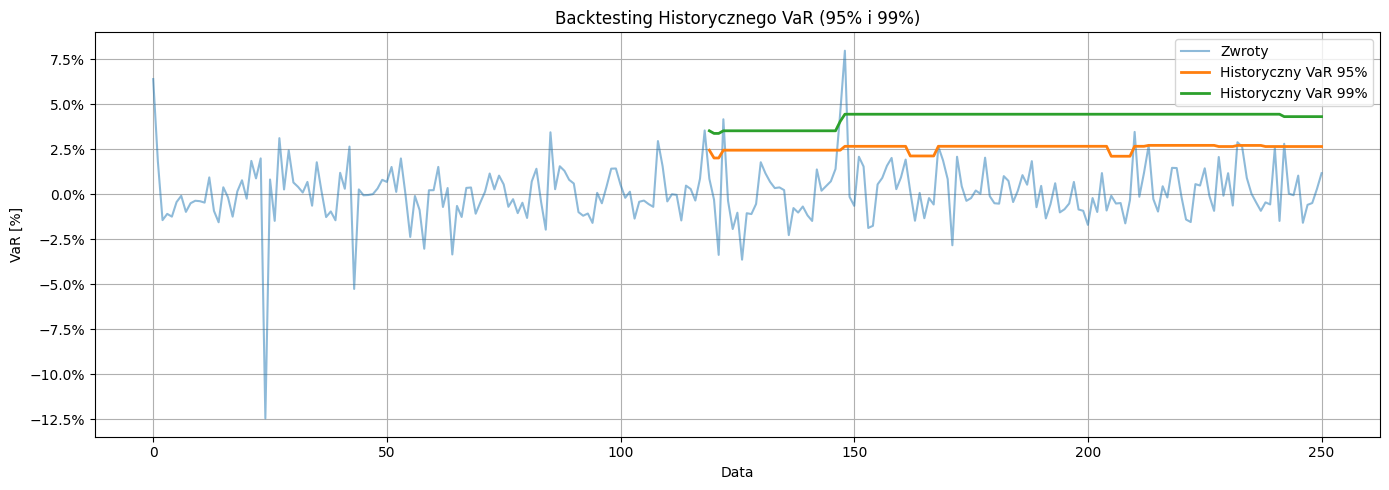

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

df = pd.DataFrame({"returns": returns})

# Parametry
window_size = 120
conf_levels = [0.95, 0.99]

# Rolling historyczny VaR
VaRs_hist = {}
for cl in conf_levels:
    VaRs_hist[cl] = df['returns'].rolling(window=window_size).quantile(cl)

# Wykres
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['returns'], label="Zwroty", alpha=0.5)

for cl in conf_levels:
    plt.plot(df.index, VaRs_hist[cl], label=f"Historyczny VaR {int(cl * 100)}%", linewidth=2)

plt.title("Backtesting Historycznego VaR (95% i 99%)")
plt.xlabel("Data")
plt.ylabel("VaR [%]")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))  # <-- oś Y w %
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Compressed VaR - tygodniowy

In [ ]:
def compressed_var_week(daily_var):
    return np.sqrt(5) * daily_var

VaR_95_list = [VaR_95,  # Parametryczna (t -Student)
        VaR_hist_95,  # Historyczna (Zwykła)
        VaR_weighted_95, # Historyczna (Ważona)
        VaR_mc_95_t,  # Monte Carlo (t - Student)
        VaR_mc_95, #Monte Carlo (ARMA(1,1))
]

VaR_99_list = [VaR_99,  # Parametryczna (t -Student)
        VaR_hist_99,  # Historyczna (Zwykła)
        VaR_weighted_99, # Historyczna (Ważona)
        VaR_mc_99_t,  # Monte Carlo (t - Student)
        VaR_mc_99, #Monte Carlo (ARMA(1,1))
]

Compressed_VaR_95_week_list = compressed_var_week(np.array(VaR_95_list))
Compressed_VaR_99_week_list = compressed_var_week(np.array(VaR_99_list))

In [70]:
import pandas as pd

comprssed_var_week_results = pd.DataFrame({
    "Compressed VaR 95%": Compressed_VaR_95_week_list * 100,
    "Compressed VaR 99%": Compressed_VaR_99_week_list * 100
}, index=[
    "Parametryczna (t-Student)",
    "Historyczna (Zwykła)",
    "Historyczna (Ważona)",
    "Monte Carlo (t-Student)",
    "Monte Carlo (ARMA(1,1))"
])

# Wyświetlenie tabeli
comprssed_var_week_results.round(4)

Compressed VaR 95%  Compressed VaR 99%
Parametryczna (t-Student)              5.3406              9.9399
Historyczna (Zwykła)                   5.9170              9.6954
Historyczna (Ważona)                   6.2655              6.4588
Monte Carlo (t-Student)                6.0297             10.8151
Monte Carlo (ARMA(1,1))                7.2706             10.3049

# Punkt 3 - dla ES

## Punkt 1.a - metoda paramteryczna z dobranym rozkładem t-studenta 

In [34]:
import numpy as np
from scipy.stats import t

# Filtrujemy dane, które przekraczają VaR (dla 95% i 99%)
size = len(logret_fuel_data)
sample = t.rvs(df=df, loc=loc, scale=scale, size=size)
exceed_VaR_95 = sample[sample > VaR_95]
exceed_VaR_99 = sample[sample > VaR_99]

# Obliczamy EVaR - średnią wartość przekraczającą VaR
ES_95 = np.mean(exceed_VaR_95)
ES_99 = np.mean(exceed_VaR_99)

# Wyniki
print(f"ES 95%: {ES_95 * 100:.4f}%")
print(f"ES 99%: {ES_99 * 100:.4f}%")

if ES_99 is not None:
    print(f"ES 99%: {ES_99 * 100:.4f}%")
else:
    print("ES 99%: brak przekroczeń (nan)")

ES 95%: 3.3016%
ES 99%: 5.0420%
ES 99%: 5.0420%


## Puntkt 1.b - meetoda historyczna

### i) zwykły

In [35]:
# Filtrujemy dane, które przekraczają VaR (dla 95% i 99%)
exceed_VaR_hist_95 = logret_fuel_data[logret_fuel_data > VaR_hist_95]
exceed_VaR_hist_99 = logret_fuel_data[logret_fuel_data > VaR_hist_99]

# Obliczamy EVaR - średnią wartość przekraczającą VaR
ES_hist_95 = np.mean(exceed_VaR_hist_95)
ES_hist_99 = np.mean(exceed_VaR_hist_99)

print(f"ES historyczna zwykła 95%: {ES_hist_95 * 100:.4f}%")
print(f"ES historyczna zwykła 99%: {ES_hist_95 * 100:.4f}%")

ES historyczna zwykła 95%: 3.8910%
ES historyczna zwykła 99%: 3.8910%


### ii) ważony

In [59]:
import numpy as np

alpha_95 = 0.95
alpha_99 = 0.99

# Parametry wag
lambda_ = 0.94
n = len(logret_fuel_data)

# Wagi wykładnicze
weights = (1 - lambda_) * (lambda_ ** np.arange(n))
weights = weights[::-1]  # Najnowsze dane mają największe wagi
weights /= weights.sum()  # Normalizacja

# Sortowanie danych i odpowiadających wag
sorted_indices = np.argsort(logret_fuel_data)
sorted_returns = logret_fuel_data[sorted_indices]
sorted_weights = weights[sorted_indices]

# Skumulowane wagi
cum_weights = np.cumsum(sorted_weights)

# Funkcja do wyszukiwania VaR przy skumulowanych wagach
def weighted_var(cum_weights, sorted_returns, alpha):
    idx = np.searchsorted(cum_weights, alpha, side="left")
    idx = min(idx, len(sorted_returns))
    return sorted_returns[idx], idx

# Obliczenie VaR i indeksu granicznego
VaR_weighted_95, idx_95 = weighted_var(cum_weights, sorted_returns, alpha_95)
VaR_weighted_99, idx_99 = weighted_var(cum_weights, sorted_returns, alpha_99)

# Obliczenie ważonego Expected Shortfall
ES_weighted_95 = np.sum(sorted_weights[idx_95:] * sorted_returns[idx_95:]) / np.sum(sorted_weights[idx_95:])
ES_weighted_99 = np.sum(sorted_weights[idx_99:] * sorted_returns[idx_99:]) / np.sum(sorted_weights[idx_99:])

# Wyniki
print(f"Historyczny VaR 95% (ważony): {VaR_weighted_95 * 100:.4f}%")
print(f"Historyczny VaR 99% (ważony): {VaR_weighted_99 * 100:.4f}%")
print(f"ES 95% (ważony): {ES_weighted_95 * 100:.4f}%")
print(f"ES 99% (ważony): {ES_weighted_99 * 100:.4f}%")


Historyczny VaR 95% (ważony): 2.8020%
Historyczny VaR 99% (ważony): 2.8884%
ES 95% (ważony): 2.8964%
ES 99% (ważony): 3.0344%


### iii) przy użyciu filtrowania szeregiem GARCH

## Podpunkt 1.c - metoda Monte Carlo 

rozkład t-Studenta

In [56]:
# Liczba losowań (symulacje Monte Carlo)
N = 10000  # Duża liczba losowań (żeby kwantyle były dokładne)
n = len(logret_fuel_data)

ES_mc_95_t_list = []
ES_mc_99_t_list = []

for _ in range(N): 
    # Symulacja zwrotów
    simulated_returns = stats.t.rvs(df, loc, scale, size=n)

    # Liczenie VaR 95% i 99% z symulowanych danych
    VaR_mc_95_t = np.percentile(simulated_returns, 100 * 0.95)
    VaR_mc_99_t = np.percentile(simulated_returns, 100 * 0.99)

    # Przefiltruj dane, które przekraczają VaR (dla 95% i 99%)
    exceed_VaR_mc_95_t = simulated_returns[simulated_returns > VaR_mc_95_t]
    exceed_VaR_mc_99_t = simulated_returns[simulated_returns > VaR_mc_99_t]

    # Oblicz średnią z tych strat (EVaR)
    ES_mc_95_t_sample = np.mean(exceed_VaR_mc_95_t)
    ES_mc_99_t_sample = np.mean(exceed_VaR_mc_99_t)

    ES_mc_95_t_list.append(ES_mc_95_t_sample)
    ES_mc_99_t_list.append(ES_mc_99_t_sample)

ES_mc_95_t = np.mean(ES_mc_95_t_list)
ES_mc_99_t = np.mean(ES_mc_99_t_list)

print(f"Monte Carlo z rozkładem t-Studenta ES 95%: {ES_mc_95_t*100:.4f}%")
print(f"Monte Carlo z rozkładem t-Studenta ES 99%: {ES_mc_99_t*100:.4f}%")

Monte Carlo z rozkładem t-Studenta ES 95%: 3.7138%
Monte Carlo z rozkładem t-Studenta ES 99%: 6.0373%


ARMA(1,1)

In [38]:
import statsmodels.api as sm

# Dopasowanie modelu ARMA(1,1)
arma_model = sm.tsa.ARIMA(logret_fuel_data, order=(1,0, 1)).fit()

# Wyciągnięcie parametrów
arparams = arma_model.arparams
maparams = arma_model.maparams
sigma = np.std(arma_model.resid, ddof=1)

# Parametry Monte Carlo
N = 100000  # Ilość symulacji
n_steps = 1  # Jednokrokowe symulacje (jednodniowe VaR)

# Symulacja procesów ARMA(1,1)
simulated_returns = []
for _ in range(N):
    # Symulacja białego szumu
    eps = np.random.normal(0, sigma, n_steps + 1)
    
    # Symulacja procesu
    x = np.zeros(n_steps + 1)
    for t in range(1, n_steps + 1):
        x[t] = arparams[0] * x[t-1] + eps[t] + maparams[0] * eps[t-1]
    
    simulated_returns.append(x[-1])  # interesuje nas ostatnia wartość (krok n_steps)

simulated_returns = np.array(simulated_returns)

# Liczenie VaR
VaR_mc_95 = np.percentile(simulated_returns, 100 * 0.95)
VaR_mc_99 = np.percentile(simulated_returns, 100 * 0.99)

ES_mc_95 = simulated_returns[simulated_returns >= VaR_mc_95].mean()
ES_mc_99 = simulated_returns[simulated_returns >= VaR_mc_99].mean()

print(f"Monte Carlo z ARMA(1,1) ES 95%: {ES_mc_95*100:.4f}%")
print(f"Monte Carlo z ARMA(1,1) ES 99%: {ES_mc_99*100:.4f}%")

c:\Users\wpyrt\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Monte Carlo z ARMA(1,1) ES 95%: 4.0728%
Monte Carlo z ARMA(1,1) ES 99%: 5.2666%


garch

In [56]:
# kod na garch

## Podsumowanie Punktu 1 (TRZEBA DODAĆ GARCH)

In [61]:
import pandas as pd

# Dane: wpisujemy wartości VaR w procentach
es_results = pd.DataFrame({
    "ES 95%": [
        ES_95 * 100,  # Parametryczna (t - Student)
        ES_hist_95*100,  # Historyczna (Zwykła)
        ES_weighted_95*100, # Historyczna (Ważona)
        ES_mc_95_t*100,  # Monte Carlo (t - Student)
        ES_mc_95*100  # Monte Carlo (ARMA(1,1))
    ],
    "ES 99%": [
        ES_99 * 100,  # Parametryczna (t - Student)
        ES_hist_99*100,  # Historyczna (Zwykła)
        ES_weighted_99*100, # Historyczna (Ważona)
        ES_mc_99_t*100,  # Monte Carlo (t - Student)
        ES_mc_99*100  # Monte Carlo (ARMA(1,1))
    ]
}, index=[
    "Parametryczna (t-Student)",
    "Historyczna (Zwykła)",
    "Historyczna (Ważona)",
    "Monte Carlo (t - Student)",
    "Monte Carlo (ARMA(1,1))"
])

# Wyświetlenie tabeli
es_results.round(4)

ES 95%  ES 99%
Parametryczna (t-Student)  3.3016  5.0420
Historyczna (Zwykła)       3.8910  6.2909
Historyczna (Ważona)       2.8964  3.0344
Monte Carlo (t - Student)  3.7138  6.0373
Monte Carlo (ARMA(1,1))    4.0728  5.2666

Backtesting -- coś nie działa

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def plot_es_backtest(returns, VaR_series, ES_series, label='Model ES'):
    """
    Tworzy wykres rzeczywistego vs prognozowanego Expected Shortfall.
    """
    # Konwersja danych na tablice numpy, jeśli są listami
    returns = np.asarray(returns)
    VaR_series = np.asarray(VaR_series)
    ES_series = np.asarray(ES_series)

    # Indeksy przekroczeń VaR (gdzie strata jest większa niż VaR)
    breaches = returns < VaR_series

    # Rzeczywisty ES – średnie straty przy przekroczeniu VaR
    realized_ES = np.full_like(returns, np.nan)
    realized_ES[breaches] = returns[breaches]

    # Wykres
    plt.figure(figsize=(12, 6))
    # Rysujemy prognozowany Expected Shortfall jako linię
    plt.plot(ES_series, label=f'{label} (prognozowany)', linestyle='--', color='orange')
    # Rysujemy rzeczywisty Expected Shortfall jako punkty w miejscach przekroczenia VaR
    plt.plot(realized_ES, label='Rzeczywisty ES (straty > VaR)', marker='o', linestyle='', color='red', alpha=0.5)
    # Rysujemy wartość VaR jako linię
    plt.plot(VaR_series, label='VaR', color='blue', alpha=0.6)
    
    plt.title('Porównanie prognozowanego i rzeczywistego Expected Shortfall')
    plt.xlabel('Czas')
    plt.ylabel('Zwrot')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



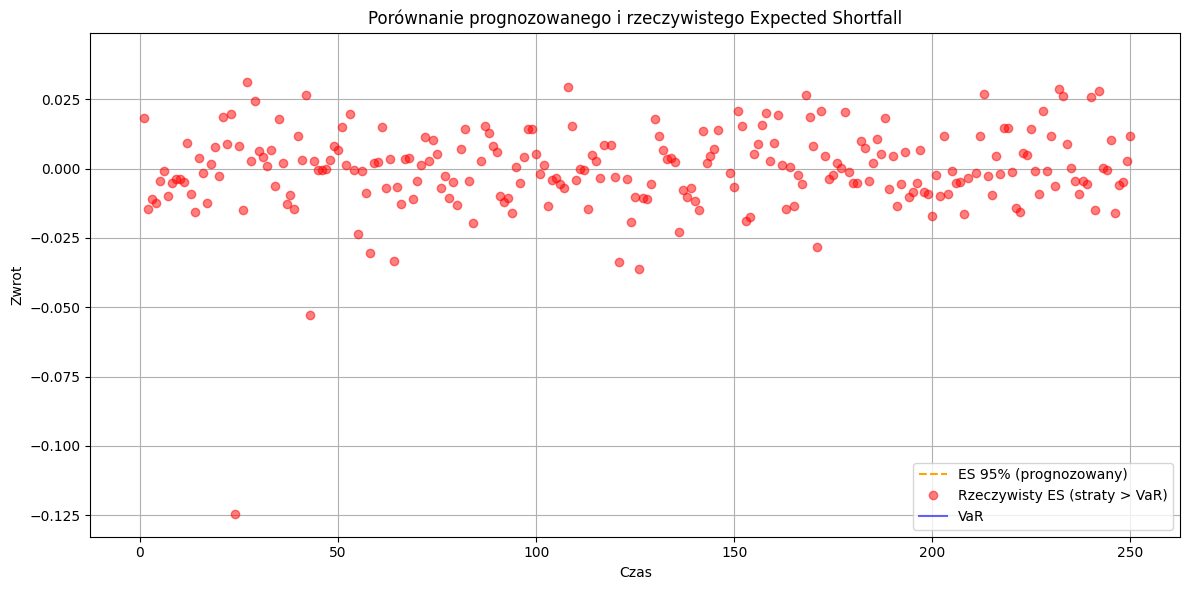

In [74]:
plot_es_backtest(logret_fuel_data, VaR_mc_95, ES_mc_95, label='ES 95%')
